In [5]:
# 수정된 키워드 추출 비교 시스템 (오류 해결 버전)

import warnings
warnings.filterwarnings('ignore')

import subprocess
import sys
import os
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
from datetime import datetime
import re
from collections import Counter

def install_requirements():
    """필요한 패키지 설치 및 환경 설정"""
    packages = [
        'konlpy',
        'keybert',
        'sentence-transformers',
        'wordcloud',
        'matplotlib',
        'seaborn',
        'scikit-learn'
    ]

    print("📦 필요한 패키지 설치 중...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

    # Java 환경 설정 강화
    try:
        print("☕ Java 환경 설정 중...")
        subprocess.check_call(["apt-get", "update"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        subprocess.check_call(["apt-get", "install", "-y", "openjdk-8-jdk"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        # Java 환경변수 설정
        os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ.get('PATH', '')}"

        # KoNLPy 데이터 다운로드
        import konlpy
        print("✓ Java 및 KoNLPy 설정 완료")
    except Exception as e:
        print(f"⚠️ Java 설정 오류: {e}")

# 설치 실행
install_requirements()

📦 필요한 패키지 설치 중...
✓ konlpy 설치 완료
✓ keybert 설치 완료
✓ sentence-transformers 설치 완료
✓ wordcloud 설치 완료
✓ matplotlib 설치 완료
✓ seaborn 설치 완료
✓ scikit-learn 설치 완료
☕ Java 환경 설정 중...
✓ Java 및 KoNLPy 설정 완료


In [9]:
# 라이브러리 임포트
from konlpy.tag import Komoran, Okt  # Okt를 백업으로 추가
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT

# 한국어 폰트 설정
def setup_korean_font():
    """한국어 폰트 설정"""
    try:
        subprocess.check_call([
            "wget", "-O", "NanumGothic.ttf",
            "https://github.com/naver/nanumfont/blob/master/fonts/NanumGothic.ttf?raw=true"
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        import matplotlib.font_manager as fm
        font_path = './NanumGothic.ttf'
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
        plt.rcParams['axes.unicode_minus'] = False

        print("✓ 한국어 폰트 설정 완료")
        return font_path
    except:
        print("⚠️ 폰트 설정 실패 - 기본 폰트 사용")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        return None

font_path = setup_korean_font()

class EnhancedKeywordExtractor:
    """개선된 키워드 추출기 (오류 해결 버전)"""

    def __init__(
        self,
        model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        stop_words: List[str] = None,
        ngram_range: Tuple[int, int] = (1, 1),
        top_n: int = 10
    ):
        # 형태소 분석기 초기화 (백업 포함)
        self.morphs = self._init_morphs()
        self.model = KeyBERT(model_name)
        self.stop_words = stop_words or [
            '하는', '있는', '위한', '통한', '되지', '하고', '이는', '그는', '것은',
            '이다', '있다', '하다', '되다', '이것', '그것', '저것', '여기', '거기'
        ]
        self.ngram_range = ngram_range
        self.top_n = top_n

    def _init_morphs(self):
        """형태소 분석기 초기화 (오류 처리 포함)"""
        try:
            print("  - Komoran 초기화 중...")
            komoran = Komoran()
            # 테스트 실행
            test_result = komoran.nouns("테스트")
            print("  ✓ Komoran 초기화 성공")
            return komoran
        except Exception as e:
            print(f"  ⚠️ Komoran 초기화 실패: {e}")
            try:
                print("  - Okt 백업 사용...")
                okt = Okt()
                test_result = okt.nouns("테스트")
                print("  ✓ Okt 초기화 성공")
                return okt
            except Exception as e2:
                print(f"  ❌ 모든 형태소 분석기 실패: {e2}")
                return None

    def _noun_tokenizer(self, text: str) -> List[str]:
        """개선된 명사 추출 (오류 처리 강화)"""
        if not text or not text.strip():
            return []

        try:
            if self.morphs is None:
                # 형태소 분석기가 없으면 간단한 토크나이징
                return self._simple_tokenizer(text)

            # 형태소 분석기 사용
            if hasattr(self.morphs, 'nouns'):
                nouns = self.morphs.nouns(text)
            else:
                # Okt의 경우
                nouns = self.morphs.nouns(text)

            # 필터링: 2글자 이상, 숫자 제외, 불용어 제외
            filtered_nouns = []
            for noun in nouns:
                if (len(noun) >= 2 and
                    not noun.isdigit() and
                    noun not in self.stop_words and
                    re.match(r'^[가-힣]+$', noun)):  # 한글만
                    filtered_nouns.append(noun)

            # 최소한의 토큰 보장
            if len(filtered_nouns) < 3:
                backup_tokens = self._simple_tokenizer(text)
                filtered_nouns.extend(backup_tokens[:5])
                filtered_nouns = list(set(filtered_nouns))  # 중복 제거

            return filtered_nouns

        except Exception as e:
            print(f"  ⚠️ 형태소 분석 오류: {e}")
            return self._simple_tokenizer(text)

    def _simple_tokenizer(self, text: str) -> List[str]:
        """백업용 간단한 토크나이저"""
        # 공백과 구두점으로 분리
        tokens = re.findall(r'[가-힣]{2,}', text)
        # 불용어 제거
        filtered = [token for token in tokens if token not in self.stop_words]
        return filtered[:10]  # 최대 10개

    def extract_keywords(self, text: str) -> List[Tuple[str, float]]:
        """키워드 추출 (오류 처리 강화)"""
        if not text.strip():
            raise ValueError("입력 텍스트가 비어 있습니다.")

        try:
            # 먼저 토큰 확인
            test_tokens = self._noun_tokenizer(text)
            if len(test_tokens) < 2:
                print("  ⚠️ 추출된 토큰이 부족합니다. 기본 KeyBERT 사용...")
                # 기본 KeyBERT로 폴백
                return self._fallback_extraction(text)

            # CountVectorizer 동적 생성
            vectorizer = CountVectorizer(
                tokenizer=self._noun_tokenizer,
                ngram_range=self.ngram_range,
                max_df=0.95,
                min_df=1,
                max_features=1000
            )

            keywords = self.model.extract_keywords(
                text,
                keyphrase_ngram_range=self.ngram_range,
                stop_words=self.stop_words,
                top_n=self.top_n,
                vectorizer=vectorizer
            )

            return self._postprocess(keywords)

        except Exception as e:
            print(f"  ⚠️ Enhanced 추출 실패: {e}")
            return self._fallback_extraction(text)

    def _fallback_extraction(self, text: str) -> List[Tuple[str, float]]:
        """백업 추출 방법"""
        try:
            keywords = self.model.extract_keywords(
                text,
                keyphrase_ngram_range=self.ngram_range,
                top_n=self.top_n
            )
            return self._postprocess(keywords)
        except:
            # 최후의 수단: 빈도 기반
            return self._frequency_based_extraction(text)

    def _frequency_based_extraction(self, text: str) -> List[Tuple[str, float]]:
        """빈도 기반 키워드 추출 (최후의 수단)"""
        tokens = self._simple_tokenizer(text)
        if not tokens:
            return []

        counter = Counter(tokens)
        total = sum(counter.values())

        keywords = []
        for word, count in counter.most_common(self.top_n):
            score = count / total
            keywords.append((word, score))

        return keywords

    def _postprocess(self, keywords: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
        """후처리"""
        if not keywords:
            return []

        filtered = []
        seen = set()

        for word, score in keywords:
            if (word not in seen and
                len(word) >= 2 and
                not word.isdigit() and
                re.match(r'^[가-힣]+$', word)):
                filtered.append((word, score))
                seen.add(word)

        return filtered

class BasicKeyBERT:
    """기본 KeyBERT (안정성 강화)"""

    def __init__(
        self,
        model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        top_n: int = 10
    ):
        self.model = KeyBERT(model_name)
        self.top_n = top_n

    def extract_keywords(self, text: str) -> List[Tuple[str, float]]:
        """기본 KeyBERT로 키워드 추출"""
        if not text.strip():
            raise ValueError("입력 텍스트가 비어 있습니다.")

        try:
            keywords = self.model.extract_keywords(
                text,
                keyphrase_ngram_range=(1, 1),
                top_n=self.top_n,
                use_mmr=True,  # 다양성 증가
                diversity=0.5
            )

            # 한글 키워드만 필터링
            filtered = []
            for word, score in keywords:
                if re.search(r'[가-힣]', word) and len(word) >= 2:
                    filtered.append((word, score))

            return filtered

        except Exception as e:
            print(f"  ⚠️ Basic KeyBERT 오류: {e}")
            return []

class KeywordComparator:
    """키워드 추출 비교 시스템 (안정성 강화)"""

    def __init__(self, top_n: int = 10):
        self.top_n = top_n
        print("🔧 키워드 추출기 초기화 중...")
        self.enhanced_extractor = EnhancedKeywordExtractor(top_n=top_n)
        self.basic_extractor = BasicKeyBERT(top_n=top_n)

        # 분석용 형태소 분석기
        try:
            self.analyzer = Komoran()
        except:
            try:
                self.analyzer = Okt()
            except:
                self.analyzer = None

        self.results = {}
        self.analysis = {}
        print("✅ 초기화 완료!")

    def compare_extraction(self, text: str) -> Dict:
        """키워드 추출 비교"""
        print("🔍 키워드 추출 시작...")

        if not text or len(text.strip()) < 10:
            raise ValueError("텍스트가 너무 짧습니다. 최소 10자 이상 입력해주세요.")

        print(f"  - 텍스트 길이: {len(text)} 문자")

        # Enhanced 추출
        print("  - Enhanced KeyBERT (Komoran + KeyBERT) 추출 중...")
        try:
            enhanced_keywords = self.enhanced_extractor.extract_keywords(text)
            print(f"    ✓ {len(enhanced_keywords)}개 키워드 추출")
        except Exception as e:
            print(f"    ❌ Enhanced 추출 실패: {e}")
            enhanced_keywords = []

        # Basic 추출
        print("  - Basic KeyBERT 추출 중...")
        try:
            basic_keywords = self.basic_extractor.extract_keywords(text)
            print(f"    ✓ {len(basic_keywords)}개 키워드 추출")
        except Exception as e:
            print(f"    ❌ Basic 추출 실패: {e}")
            basic_keywords = []

        # 최소한의 결과 보장
        if not enhanced_keywords and not basic_keywords:
            raise ValueError("두 방법 모두 키워드 추출에 실패했습니다.")

        self.results = {
            'enhanced': enhanced_keywords,
            'basic': basic_keywords,
            'text': text
        }

        print("✅ 키워드 추출 완료!")
        return self.results

    def analyze_korean_characteristics(self) -> Dict:
        """한국어 특성 분석 (안정성 강화)"""
        print("\n📊 한국어 특성 분석 중...")

        enhanced_words = [word for word, score in self.results['enhanced']]
        basic_words = [word for word, score in self.results['basic']]

        # 안전한 분석
        analysis = {
            'noun_ratio': {
                'enhanced': self._safe_calculate_noun_ratio(enhanced_words),
                'basic': self._safe_calculate_noun_ratio(basic_words)
            },
            'meaningful_ratio': {
                'enhanced': self._calculate_meaningful_ratio(enhanced_words),
                'basic': self._calculate_meaningful_ratio(basic_words)
            },
            'score_distribution': {
                'enhanced': self._get_score_stats(self.results['enhanced']),
                'basic': self._get_score_stats(self.results['basic'])
            }
        }

        # 개선도 계산
        analysis['noun_ratio']['improvement'] = (
            analysis['noun_ratio']['enhanced'] - analysis['noun_ratio']['basic']
        )
        analysis['meaningful_ratio']['improvement'] = (
            analysis['meaningful_ratio']['enhanced'] - analysis['meaningful_ratio']['basic']
        )

        # 품질 점수
        enhanced_quality = self._calculate_quality_score(self.results['enhanced'])
        basic_quality = self._calculate_quality_score(self.results['basic'])

        analysis['quality_score'] = {
            'enhanced': enhanced_quality,
            'basic': basic_quality,
            'improvement': enhanced_quality - basic_quality
        }

        self.analysis = analysis
        print("✅ 한국어 특성 분석 완료!")
        return analysis

    def _safe_calculate_noun_ratio(self, words: List[str]) -> float:
        """안전한 명사 비율 계산"""
        if not words or self.analyzer is None:
            return 0.5  # 기본값

        noun_count = 0
        for word in words:
            try:
                if hasattr(self.analyzer, 'pos'):
                    pos_tags = self.analyzer.pos(word)
                    if any(tag.startswith('N') for _, tag in pos_tags):
                        noun_count += 1
                else:
                    # 간단한 휴리스틱: 한글 2글자 이상이면 명사로 간주
                    if len(word) >= 2 and re.match(r'^[가-힣]+$', word):
                        noun_count += 1
            except:
                continue

        return noun_count / len(words) if words else 0.0

    def _calculate_meaningful_ratio(self, words: List[str]) -> float:
        """종합적 의미있는 단어 비율"""
        if not words:
            return 0.0

        meaningful_count = 0
        for word in words:
            score = 0

            # 1. 기본 조건 (필수)
            if len(word) >= 2 and re.match(r'^[가-힣]+$', word):
                score += 1

                # 2. 길이 보너스
                if len(word) >= 3:
                    score += 1
                if len(word) >= 4:
                    score += 1

                # 3. 숫자 포함 여부 (감점)
                if re.search(r'\d', word):
                    score -= 1

                # 4. 일반적인 불용어 확인 (감점)
                common_stopwords = ['이것', '그것', '저것', '여기', '거기', '저기', '이런', '그런', '저런']
                if word in common_stopwords:
                    score -= 2

            # 점수가 1 이상이면 의미있는 단어
            if score >= 1:
                meaningful_count += 1

        return meaningful_count / len(words)

    def _get_score_stats(self, keywords: List[Tuple[str, float]]) -> Dict:
        """점수 통계"""
        if not keywords:
            return {'mean': 0, 'std': 0, 'max': 0, 'min': 0}

        scores = [score for _, score in keywords]
        return {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'max': np.max(scores),
            'min': np.min(scores)
        }

    def _calculate_quality_score(self, keywords: List[Tuple[str, float]]) -> float:
        """품질 점수 계산"""
        if not keywords:
            return 0.0

        scores = [score for _, score in keywords]
        words = [word for word, _ in keywords]

        score_mean = np.mean(scores)
        length_diversity = np.std([len(word) for word in words]) if len(set(len(word) for word in words)) > 1 else 0

        return score_mean + (length_diversity * 0.1)

    def analyze_overlap(self) -> Dict:
        """키워드 겹침 분석"""
        print("\n🔄 키워드 겹침 분석 중...")

        enhanced_words = set(word for word, score in self.results['enhanced'])
        basic_words = set(word for word, score in self.results['basic'])

        common_words = enhanced_words & basic_words
        enhanced_unique = enhanced_words - basic_words
        basic_unique = basic_words - enhanced_words

        total_unique = len(enhanced_words | basic_words)

        return {
            'common_keywords': list(common_words),
            'enhanced_unique': list(enhanced_unique),
            'basic_unique': list(basic_unique),
            'overlap_ratio': len(common_words) / total_unique if total_unique > 0 else 0,
            'enhanced_uniqueness': len(enhanced_unique) / len(enhanced_words) if enhanced_words else 0,
            'basic_uniqueness': len(basic_unique) / len(basic_words) if basic_words else 0
        }

    def create_simple_comparison(self):
        """간단한 비교 출력"""
        print("\n" + "="*80)
        print("키워드 추출 결과 비교")
        print("="*80)

        print(f"{'Rank':<4} {'Enhanced KeyBERT':<30} {'Score':<8} {'Basic KeyBERT':<30} {'Score':<8}")
        print("-"*80)

        max_len = max(len(self.results['enhanced']), len(self.results['basic']))

        for i in range(max_len):
            rank = i + 1

            if i < len(self.results['enhanced']):
                e_word, e_score = self.results['enhanced'][i]
                e_display = f"{e_word} ({e_score:.3f})"
            else:
                e_display = "-"

            if i < len(self.results['basic']):
                b_word, b_score = self.results['basic'][i]
                b_display = f"{b_word} ({b_score:.3f})"
            else:
                b_display = "-"

            print(f"{rank:<4} {e_display:<30} {'':<8} {b_display:<30}")

        # 간단한 분석
        if hasattr(self, 'analysis') and self.analysis:
            print("\n📊 분석 요약:")
            print(f"명사 추출 정확도 - Enhanced: {self.analysis['noun_ratio']['enhanced']*100:.1f}%, Basic: {self.analysis['noun_ratio']['basic']*100:.1f}%")
            print(f"의미있는 단어 비율 - Enhanced: {self.analysis['meaningful_ratio']['enhanced']*100:.1f}%, Basic: {self.analysis['meaningful_ratio']['basic']*100:.1f}%")

    def run_simple_comparison(self, text: str):
        """간단한 비교 실행"""
        print("🚀 키워드 추출 비교 시작!")
        print("="*60)

        try:
            # 키워드 추출
            self.compare_extraction(text)

            # 분석
            self.analyze_korean_characteristics()

            # 결과 출력
            self.create_simple_comparison()

            print("\n✅ 비교 완료!")

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            import traceback
            traceback.print_exc()

# 사용 예시
if __name__ == "__main__":
    # 테스트용 샘플 텍스트
    sample_text = """
개인정보보호위원회는 국민 생활과 밀접한 분야에서 실질적이고 효율적인 자율규제 활동이 이뤄지도록 지원체계를 개편하고 개인정보 자율규제 제도를 내실화하기 위해 올해 개인정보 자율규제 운영계획을 마련했다고 26일 밝혔다.

개인정보 자율규제 제도는 사업자가 스스로 개인정보 보호 역량을 갖추고 개인정보를 안전하게 활용하도록 지원하는 제도다.

이는 정부 규제의 한계를 보완하고 민간의 능동적 개인정보 보호 환경 조성을 위해 개인정보 보호법 제13조에 따라 정부가 지정한 자율규제단체의 활동을 지원한다.

그동안 다양한 분야의 자율규제단체를 일률적으로 지원해 분야별 특성에 맞는 실효적 자율규제 활동에 한계가 있었다. 지난 2022년 도입한 민관협력 자율규제의 효과성을 높이기 위해 운영방법에 대한 개선 필요성도 제기돼 왔다.

이에 따라 개인정보위는 이번 운영계획을 통해 자율규제단체별 특성과 현황에 맞는 맞춤형 지원을 제공하기 위해 지원체계를 재설계했다.

특히 올해는 공인중개사, 여행업, 노인복지관 등 국민 생활과 밀접하면서 대규모로 개인정보를 다루는 3개 분야를 집중지원단체로 선정해 개인정보 처리방침 작성 컨설팅과 개인정보 수집 때 동의서 마련 홍보 등 캠페인을 추진한다.

또한 온라인플랫폼 4개 분야의 분야별 자율규약을 통합규약으로 재편하고 인센티브 제공기간을 통일해 명확히 했다.

아울러 민관협력 자율규제에 새로 참여를 희망하는 자율규제단체가 규약을 마련하는 데 활용할 수 있도록 표준규약도 제공한다.

한편, 개인정보위는 운영계획의 일환으로 개인정보 보호 자율규제 단체 지정 및 운영 등에 관한 규정을 개정하고 활동 결과가 우수한 자율규제단체와 소속 개인정보처리자에 대해 포상, 과징금·과태료 감경, 사전 실태점검 면제 규정 등을 신설해 인센티브를 다양화·현실화했다.

이와 함께 개정된 규정에 따라 개인정보위는 기존의 자율규제협의회를 학계·법조계·소비자단체·산업계 전문가를 중심으로 하는 개인정보 보호 자율규제위원회로 개편하고 이날 제1기 위원을 위촉했다.

자율규제위원회는 개인정보 분야에 학식과 경험이 풍부한 인사들과 개인정보위 당연직 위원 1명을 포함해 13인으로 구성됐으며 위원장은 권헌영 고려대 정보보호대학원 교수가 맡았다.

위원들은 앞으로 임기 2년 동안 자율규제단체 지정·승인, 자율규제단체 연간 수행계획 및 활동 평가, 자율규약 검토 등 자율규제 업무의 전반적 사항을 심의할 예정이다.

문의: 개인정보보호위원회 개인정보정책국 자율보호정책과(02-2100-3089)

[출처] 대한민국 정책브리핑(www.korea.kr)
    """

    print("🧪 테스트 실행 중...")
    comparator = KeywordComparator(top_n=10)
    comparator.run_simple_comparison(sample_text)

    print("\n" + "="*60)
    print("실제 사용법:")
    print('text = "여기에 실제 뉴스 기사 입력"')
    print('comparator = KeywordComparator(top_n=10)')
    print('comparator.run_simple_comparison(text)')

⚠️ 폰트 설정 실패 - 기본 폰트 사용
🧪 테스트 실행 중...
🔧 키워드 추출기 초기화 중...
  - Komoran 초기화 중...
  ✓ Komoran 초기화 성공
✅ 초기화 완료!
🚀 키워드 추출 비교 시작!
🔍 키워드 추출 시작...
  - 텍스트 길이: 1266 문자
  - Enhanced KeyBERT (Komoran + KeyBERT) 추출 중...
  ⚠️ 형태소 분석 오류: java.lang.NullPointerException
  ⚠️ 형태소 분석 오류: java.lang.NullPointerException
  ⚠️ Enhanced 추출 실패: max_df corresponds to < documents than min_df
    ✓ 10개 키워드 추출
  - Basic KeyBERT 추출 중...
    ✓ 9개 키워드 추출
✅ 키워드 추출 완료!

📊 한국어 특성 분석 중...
✅ 한국어 특성 분석 완료!

키워드 추출 결과 비교
Rank Enhanced KeyBERT               Score    Basic KeyBERT                  Score   
--------------------------------------------------------------------------------
1    개인정보보호위원회는 (0.784)                      개인정보보호위원회는 (0.784)            
2    개인정보보호위원회 (0.775)                       개인정보보호위원회 (0.775)             
3    자율규제협의회를 (0.676)                        자율규제위원회는 (0.647)              
4    자율규제위원회는 (0.647)                        자율규제 (0.525)                  
5    자율규제단체 (0.618)                        

In [1]:
# 키워드 추출기 하이퍼파라미터 최적화 시스템
# Colab 환경용 - 정답 없는 정성적 평가 방식

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
from datetime import datetime
from itertools import product
from collections import Counter
import re
from typing import List, Tuple, Dict, Any
warnings.filterwarnings('ignore')

# 필요한 패키지 설치
import subprocess
import sys

def install_requirements():
    """필요한 패키지 설치"""
    packages = [
        'konlpy',
        'keybert',
        'sentence-transformers',
        'scikit-learn',
        'wordcloud',
        'plotly'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ konlpy 설치 완료
✓ keybert 설치 완료
✓ sentence-transformers 설치 완료
✓ scikit-learn 설치 완료
✓ wordcloud 설치 완료
✓ plotly 설치 완료


In [5]:


# 라이브러리 임포트
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# 기존 KeywordExtractor 클래스 (수정된 버전)
class KeywordExtractor:
    def __init__(
        self,
        model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        stop_words: List[str] = None,
        ngram_range: Tuple[int, int] = (1, 1),
        top_n: int = 10
    ):
        """키워드 추출기 초기화"""
        self.model_name = model_name
        self.komoran = Komoran()
        self.model = KeyBERT(model_name)
        self.stop_words = stop_words or ['하는', '있는', '위한', '통한', '되지', '하고']
        self.ngram_range = ngram_range
        self.top_n = top_n

        # CountVectorizer 사전 초기화
        self.vectorizer = CountVectorizer(
            tokenizer=self._noun_tokenizer,
            ngram_range=ngram_range,
            max_df=1.0,
            min_df=1
        )

    def _noun_tokenizer(self, text: str) -> List[str]:
        """명사 추출 및 2글자 이상 필터링"""
        try:
            nouns = self.komoran.nouns(text)
            return [noun for noun in nouns if len(noun) >= 2]
        except Exception as e:
            print(f"형태소 분석 중 오류 발생: {e}")
            return []

    def extract_keywords(self, text: str) -> List[Tuple[str, float]]:
        """텍스트에서 키워드 추출"""
        if not text.strip():
            raise ValueError("입력 텍스트가 비어 있습니다.")

        keywords = self.model.extract_keywords(
            text,
            keyphrase_ngram_range=self.ngram_range,
            stop_words=self.stop_words,
            top_n=self.top_n,
            vectorizer=self.vectorizer
        )

        return self._postprocess(keywords)

    def _postprocess(self, keywords: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
        """추출 결과 후처리"""
        filtered = [(word, score) for word, score in keywords if not word.isdigit()]
        seen = set()
        return [(word, score) for word, score in filtered if not (word in seen or seen.add(word))]

    def add_stop_words(self, new_stop_words: List[str]):
        """불용어 추가"""
        self.stop_words.extend(new_stop_words)
        self.vectorizer = CountVectorizer(
            tokenizer=self._noun_tokenizer,
            ngram_range=self.ngram_range,
            max_df=1.0,
            min_df=1,
            stop_words=self.stop_words
        )

class KeywordExtractorOptimizer:
    """키워드 추출기 하이퍼파라미터 최적화 클래스"""

    def __init__(self, test_articles: List[str]):
        """
        초기화
        Args:
            test_articles: 테스트할 뉴스 기사 리스트
        """
        self.test_articles = test_articles
        self.results = {}
        self.performance_metrics = {}

        # 하이퍼파라미터 그리드 정의
        self.hyperparameter_grid = {
            'model_name': [
                'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
                'klue/bert-base',
                'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'
            ],
            'ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
            'top_n': [5, 10],
            'stop_words_type': ['basic', 'extended']
        }

        # 확장 불용어 리스트
        self.extended_stop_words = [
            '하는', '있는', '위한', '통한', '되지', '하고', '이는', '그는', '그녀는',
            '이것', '그것', '저것', '여기', '거기', '저기', '때문', '따라', '대해',
            '관련', '경우', '때문에', '따라서', '그래서', '하지만', '그러나', '또한',
            '뿐만', '아니라', '이번', '지난', '다음', '올해', '작년', '내년'
        ]

        print(f"🚀 키워드 추출기 최적화 시스템 초기화")
        print(f"📰 테스트 기사 수: {len(test_articles)}")
        print(f"🔧 총 파라미터 조합 수: {self._calculate_total_combinations()}")

    def _calculate_total_combinations(self) -> int:
        """총 파라미터 조합 수 계산"""
        total = 1
        for key, values in self.hyperparameter_grid.items():
            total *= len(values)
        return total

    def _get_stop_words(self, stop_words_type: str) -> List[str]:
        """불용어 타입에 따른 불용어 리스트 반환"""
        if stop_words_type == 'basic':
            return ['하는', '있는', '위한', '통한', '되지', '하고']
        else:  # extended
            return self.extended_stop_words

    def _calculate_intrinsic_metrics(self, keywords_list: List[List[Tuple[str, float]]],
                                   execution_time: float) -> Dict[str, float]:
        """내재적 평가 지표 계산"""
        all_keywords = []
        all_scores = []
        keyword_lengths = []

        for keywords in keywords_list:
            for word, score in keywords:
                all_keywords.append(word)
                all_scores.append(score)
                keyword_lengths.append(len(word))

        if not all_keywords:
            return {
                'diversity_ratio': 0.0,
                'avg_keyword_length': 0.0,
                'score_variance': 0.0,
                'avg_score': 0.0,
                'execution_time': execution_time
            }

        # 다양성 비율 (유니크 키워드 / 전체 키워드)
        diversity_ratio = len(set(all_keywords)) / len(all_keywords)

        # 평균 키워드 길이
        avg_keyword_length = np.mean(keyword_lengths)

        # 점수 분산 (높을수록 키워드 간 차별화가 잘 됨)
        score_variance = np.var(all_scores)

        # 평균 점수
        avg_score = np.mean(all_scores)

        return {
            'diversity_ratio': diversity_ratio,
            'avg_keyword_length': avg_keyword_length,
            'score_variance': score_variance,
            'avg_score': avg_score,
            'execution_time': execution_time
        }

    def run_optimization(self):
        """하이퍼파라미터 최적화 실행"""
        print("\n🔄 하이퍼파라미터 최적화 시작...")

        # 모든 파라미터 조합 생성
        param_combinations = list(product(
            self.hyperparameter_grid['model_name'],
            self.hyperparameter_grid['ngram_range'],
            self.hyperparameter_grid['top_n'],
            self.hyperparameter_grid['stop_words_type']
        ))

        total_combinations = len(param_combinations)

        for i, (model_name, ngram_range, top_n, stop_words_type) in enumerate(param_combinations):
            print(f"\n📊 진행률: {i+1}/{total_combinations} ({(i+1)/total_combinations*100:.1f}%)")
            print(f"🔧 테스트 중: {model_name.split('/')[-1]}, {ngram_range}, top_n={top_n}, stop_words={stop_words_type}")

            try:
                # 키워드 추출기 초기화
                start_time = time.time()

                stop_words = self._get_stop_words(stop_words_type)
                extractor = KeywordExtractor(
                    model_name=model_name,
                    stop_words=stop_words,
                    ngram_range=ngram_range,
                    top_n=top_n
                )

                # 각 기사에 대해 키워드 추출
                article_results = []
                for j, article in enumerate(self.test_articles):
                    try:
                        keywords = extractor.extract_keywords(article)
                        article_results.append(keywords)
                        print(f"  📰 기사 {j+1}: {len(keywords)}개 키워드 추출")
                    except Exception as e:
                        print(f"  ⚠️ 기사 {j+1} 처리 오류: {e}")
                        article_results.append([])

                execution_time = time.time() - start_time

                # 결과 저장
                param_key = f"{model_name.split('/')[-1]}_{ngram_range}_{top_n}_{stop_words_type}"
                self.results[param_key] = {
                    'parameters': {
                        'model_name': model_name,
                        'ngram_range': ngram_range,
                        'top_n': top_n,
                        'stop_words_type': stop_words_type
                    },
                    'keywords_by_article': article_results,
                    'execution_time': execution_time
                }

                # 성능 지표 계산
                metrics = self._calculate_intrinsic_metrics(article_results, execution_time)
                self.performance_metrics[param_key] = metrics

                print(f"  ✅ 완료 (소요시간: {execution_time:.2f}초)")

            except Exception as e:
                print(f"  ❌ 파라미터 조합 실행 오류: {e}")
                continue

        print("\n🎉 하이퍼파라미터 최적화 완료!")

    def analyze_results(self):
        """결과 분석 및 최적 파라미터 추천"""
        print("\n📊 결과 분석 중...")

        if not self.performance_metrics:
            print("❌ 분석할 결과가 없습니다.")
            return

        # DataFrame으로 변환
        df_metrics = pd.DataFrame(self.performance_metrics).T

        # 각 지표별 최고 성능 파라미터 찾기
        best_params = {}

        for metric in ['diversity_ratio', 'avg_score', 'score_variance']:
            best_idx = df_metrics[metric].idxmax()
            best_params[metric] = {
                'param_combination': best_idx,
                'score': df_metrics.loc[best_idx, metric],
                'parameters': self.results[best_idx]['parameters']
            }

        # 실행 시간이 가장 빠른 조합
        fastest_idx = df_metrics['execution_time'].idxmin()
        best_params['fastest'] = {
            'param_combination': fastest_idx,
            'time': df_metrics.loc[fastest_idx, 'execution_time'],
            'parameters': self.results[fastest_idx]['parameters']
        }

        # 종합 점수 계산 (정규화된 지표들의 가중 평균)
        normalized_df = df_metrics.copy()
        for col in ['diversity_ratio', 'avg_score', 'score_variance']:
            normalized_df[col] = (df_metrics[col] - df_metrics[col].min()) / (df_metrics[col].max() - df_metrics[col].min())

        # 실행 시간은 역정규화 (빠를수록 좋음)
        normalized_df['execution_time_norm'] = 1 - (df_metrics['execution_time'] - df_metrics['execution_time'].min()) / (df_metrics['execution_time'].max() - df_metrics['execution_time'].min())

        # 종합 점수 (가중치: 다양성 30%, 평균점수 30%, 점수분산 20%, 실행시간 20%)
        normalized_df['composite_score'] = (
            normalized_df['diversity_ratio'] * 0.3 +
            normalized_df['avg_score'] * 0.3 +
            normalized_df['score_variance'] * 0.2 +
            normalized_df['execution_time_norm'] * 0.2
        )
        df_metrics['composite_score'] = normalized_df['composite_score']

        best_overall_idx = normalized_df['composite_score'].idxmax()
        best_params['overall'] = {
            'param_combination': best_overall_idx,
            'composite_score': normalized_df.loc[best_overall_idx, 'composite_score'],
            'parameters': self.results[best_overall_idx]['parameters']
        }

        self.best_params = best_params
        self.df_metrics = df_metrics

        # 결과 출력
        print("\n🏆 최적 파라미터 조합 분석 결과")
        print("=" * 60)

        for criterion, info in best_params.items():
            print(f"\n📈 {criterion.upper()} 기준 최적 조합:")
            params = info['parameters']
            print(f"  모델: {params['model_name'].split('/')[-1]}")
            print(f"  N-gram: {params['ngram_range']}")
            print(f"  Top-N: {params['top_n']}")
            print(f"  불용어: {params['stop_words_type']}")

            if criterion == 'fastest':
                print(f"  실행시간: {info['time']:.2f}초")
            elif criterion == 'overall':
                print(f"  종합점수: {info['composite_score']:.4f}")
            else:
                print(f"  {criterion}: {info['score']:.4f}")

        print("\n" + "=" * 60)

    def display_keyword_results(self, top_combinations: int = 5):
        """상위 조합들의 키워드 추출 결과 출력"""
        print(f"\n📝 상위 {top_combinations}개 조합의 키워드 추출 결과")
        print("=" * 80)

        # 종합 점수 기준 상위 조합들
        top_indices = self.df_metrics.nlargest(top_combinations, 'composite_score').index

        for rank, param_key in enumerate(top_indices, 1):
            print(f"\n🏅 {rank}위: {param_key}")
            print("-" * 50)

            params = self.results[param_key]['parameters']
            print(f"파라미터: {params['model_name'].split('/')[-1]}, {params['ngram_range']}, top_n={params['top_n']}, {params['stop_words_type']}")

            keywords_by_article = self.results[param_key]['keywords_by_article']

            for i, keywords in enumerate(keywords_by_article):
                print(f"\n📰 기사 {i+1} 키워드:")
                if keywords:
                    keyword_str = ", ".join([f"{word}({score:.3f})" for word, score in keywords[:10]])
                    print(f"  {keyword_str}")
                else:
                    print("  키워드 추출 실패")

            metrics = self.performance_metrics[param_key]
            print(f"\n📊 성능 지표:")
            print(f"  다양성: {metrics['diversity_ratio']:.3f}")
            print(f"  평균점수: {metrics['avg_score']:.3f}")
            print(f"  점수분산: {metrics['score_variance']:.3f}")
            print(f"  실행시간: {metrics['execution_time']:.2f}초")

    def create_visualizations(self):
        """결과 시각화"""
        print("\n🎨 시각화 생성 중...")

        # 한글 폰트 설정
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        # 1. 파라미터별 성능 히트맵
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Hyperparameter Performance Analysis', fontsize=16, fontweight='bold')

        metrics_to_plot = ['diversity_ratio', 'avg_score', 'score_variance', 'execution_time']
        metric_titles = ['Diversity Ratio', 'Average Score', 'Score Variance', 'Execution Time (sec)']

        for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
            row = idx // 2
            col = idx % 2

            # 파라미터별 평균 성능 계산
            param_performance = {}

            for param_key, metrics in self.performance_metrics.items():
                params = self.results[param_key]['parameters']

                for param_name, param_value in params.items():
                    if param_name not in param_performance:
                        param_performance[param_name] = {}
                    if param_value not in param_performance[param_name]:
                        param_performance[param_name][param_value] = []
                    param_performance[param_name][param_value].append(metrics[metric])

            # 히트맵 데이터 준비 (ngram_range 기준)
            ngram_data = []
            ngram_labels = []
            for ngram, values in param_performance['ngram_range'].items():
                ngram_data.append(np.mean(values))
                ngram_labels.append(str(ngram))

            # 바 차트로 표시
            axes[row, col].bar(ngram_labels, ngram_data)
            axes[row, col].set_title(f'{title} by N-gram Range')
            axes[row, col].set_xlabel('N-gram Range')
            axes[row, col].set_ylabel(title)
            axes[row, col].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. 모델별 성능 비교
        fig, ax = plt.subplots(figsize=(15, 8))

        model_performance = {}
        for param_key, metrics in self.performance_metrics.items():
            model_name = self.results[param_key]['parameters']['model_name'].split('/')[-1]
            if model_name not in model_performance:
                model_performance[model_name] = []
            model_performance[model_name].append(metrics['diversity_ratio'])

        models = list(model_performance.keys())
        diversity_scores = [model_performance[model] for model in models]

        box_plot = ax.boxplot(diversity_scores, labels=models, patch_artist=True)
        ax.set_title('Diversity Ratio by Model')
        ax.set_ylabel('Diversity Ratio')
        ax.tick_params(axis='x', rotation=45)

        # 색상 설정
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. 종합 성능 스코어 히트맵
        fig, ax = plt.subplots(figsize=(12, 8))

        # 파라미터 조합별 종합 점수 매트릭스 생성
        pivot_data = []
        param_labels = []

        for param_key in self.df_metrics.index:
            params = self.results[param_key]['parameters']
            label = f"{params['model_name'].split('/')[-1][:10]}\n{params['ngram_range']}\ntop_{params['top_n']}"
            param_labels.append(label)

            scores = [
                self.performance_metrics[param_key]['diversity_ratio'],
                self.performance_metrics[param_key]['avg_score'],
                self.performance_metrics[param_key]['score_variance'],
                1 / (self.performance_metrics[param_key]['execution_time'] + 1)  # 역수로 변환
            ]
            pivot_data.append(scores)

        # 상위 10개만 표시
        top_10_indices = self.df_metrics.nlargest(10, 'composite_score').index
        top_10_data = []
        top_10_labels = []

        for param_key in top_10_indices:
            params = self.results[param_key]['parameters']
            label = f"{params['model_name'].split('/')[-1][:10]}\n{params['ngram_range']}\ntop_{params['top_n']}"
            top_10_labels.append(label)

            scores = [
                self.performance_metrics[param_key]['diversity_ratio'],
                self.performance_metrics[param_key]['avg_score'],
                self.performance_metrics[param_key]['score_variance'],
                1 / (self.performance_metrics[param_key]['execution_time'] + 1)
            ]
            top_10_data.append(scores)

        sns.heatmap(
            np.array(top_10_data).T,
            xticklabels=top_10_labels,
            yticklabels=['Diversity', 'Avg Score', 'Score Var', 'Speed'],
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            ax=ax
        )
        ax.set_title('Top 10 Parameter Combinations Performance Heatmap')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('top_combinations_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. 워드클라우드 (최적 조합의 키워드들)
        try:
            best_param_key = self.best_params['overall']['param_combination']
            best_keywords = self.results[best_param_key]['keywords_by_article']

            # 모든 키워드 수집
            all_keywords = {}
            for keywords in best_keywords:
                for word, score in keywords:
                    if word in all_keywords:
                        all_keywords[word] += score
                    else:
                        all_keywords[word] = score

            if all_keywords:
                wordcloud = WordCloud(
                    font_path=None,  # 시스템 기본 폰트 사용
                    width=800,
                    height=400,
                    background_color='white',
                    max_words=50
                ).generate_from_frequencies(all_keywords)

                plt.figure(figsize=(12, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title('Best Parameter Combination - Extracted Keywords', fontsize=16)
                plt.tight_layout()
                plt.savefig('best_keywords_wordcloud.png', dpi=300, bbox_inches='tight')
                plt.show()

        except Exception as e:
            print(f"⚠️ 워드클라우드 생성 오류: {e}")

        print("✅ 시각화 완료!")

    def save_results(self):
        """결과 저장"""
        print("\n💾 결과 저장 중...")

        # 상세 결과 CSV 저장
        detailed_results = []
        for param_key, result in self.results.items():
            params = result['parameters']
            metrics = self.performance_metrics[param_key]

            row = {
                'parameter_combination': param_key,
                'model_name': params['model_name'],
                'ngram_range': str(params['ngram_range']),
                'top_n': params['top_n'],
                'stop_words_type': params['stop_words_type'],
                'diversity_ratio': metrics['diversity_ratio'],
                'avg_keyword_length': metrics['avg_keyword_length'],
                'score_variance': metrics['score_variance'],
                'avg_score': metrics['avg_score'],
                'execution_time': metrics['execution_time']
            }
            detailed_results.append(row)

        df_results = pd.DataFrame(detailed_results)
        df_results.to_csv('keyword_extractor_optimization_results.csv', index=False, encoding='utf-8-sig')

        # 최적 파라미터 JSON 저장
        optimization_summary = {
            'optimization_info': {
                'num_articles': len(self.test_articles),
                'total_combinations': len(self.results),
                'optimization_date': datetime.now().isoformat()
            },
            'best_parameters': self.best_params,
            'sample_results': {
                param_key: {
                    'parameters': result['parameters'],
                    'sample_keywords': [keywords[:3] for keywords in result['keywords_by_article'][:2]]  # 처음 2개 기사의 상위 3개 키워드만
                }
                for param_key, result in list(self.results.items())[:5]  # 처음 5개 조합만
            }
        }

        with open('keyword_optimization_summary.json', 'w', encoding='utf-8') as f:
            json.dump(optimization_summary, f, ensure_ascii=False, indent=2)

        print("✅ 결과 저장 완료!")
        print("  - keyword_extractor_optimization_results.csv: 상세 결과")
        print("  - keyword_optimization_summary.json: 최적화 요약")

    def generate_report(self):
        """최적화 보고서 생성"""
        print("\n📋 최적화 보고서 생성 중...")

        report = []
        report.append("=" * 80)
        report.append("키워드 추출기 하이퍼파라미터 최적화 보고서")
        report.append("=" * 80)
        report.append(f"최적화 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"테스트 기사 수: {len(self.test_articles)}")
        report.append(f"테스트 파라미터 조합 수: {len(self.results)}")
        report.append("")

        # 최적 파라미터 요약
        report.append("🏆 최적 파라미터 조합")
        report.append("-" * 40)

        overall_best = self.best_params['overall']
        params = overall_best['parameters']
        report.append(f"📈 종합 최적 조합 (점수: {overall_best['composite_score']:.4f}):")
        report.append(f"  • 모델: {params['model_name']}")
        report.append(f"  • N-gram 범위: {params['ngram_range']}")
        report.append(f"  • Top-N: {params['top_n']}")
        report.append(f"  • 불용어 타입: {params['stop_words_type']}")
        report.append("")

        # 각 기준별 최적 조합
        for criterion, info in self.best_params.items():
            if criterion == 'overall':
                continue

            report.append(f"📊 {criterion.upper()} 기준 최적:")
            params = info['parameters']
            report.append(f"  • 모델: {params['model_name'].split('/')[-1]}")
            report.append(f"  • N-gram: {params['ngram_range']}")
            report.append(f"  • Top-N: {params['top_n']}")
            report.append(f"  • 불용어: {params['stop_words_type']}")

            if criterion == 'fastest':
                report.append(f"  • 실행시간: {info['time']:.2f}초")
            else:
                report.append(f"  • {criterion}: {info['score']:.4f}")
            report.append("")

        # 주요 발견사항
        report.append("🔍 주요 발견사항")
        report.append("-" * 40)

        # 모델별 성능 분석
        model_performance = {}
        for param_key, metrics in self.performance_metrics.items():
            model_name = self.results[param_key]['parameters']['model_name'].split('/')[-1]
            if model_name not in model_performance:
                model_performance[model_name] = []
            model_performance[model_name].append(metrics['diversity_ratio'])

        best_model = max(model_performance.keys(), key=lambda x: np.mean(model_performance[x]))
        report.append(f"• 최고 성능 모델: {best_model}")

        # N-gram 분석
        ngram_performance = {}
        for param_key, metrics in self.performance_metrics.items():
            ngram = str(self.results[param_key]['parameters']['ngram_range'])
            if ngram not in ngram_performance:
                ngram_performance[ngram] = []
            ngram_performance[ngram].append(metrics['diversity_ratio'])

        best_ngram = max(ngram_performance.keys(), key=lambda x: np.mean(ngram_performance[x]))
        report.append(f"• 최적 N-gram 범위: {best_ngram}")

        # Top-N 분석
        topn_performance = {}
        for param_key, metrics in self.performance_metrics.items():
            topn = self.results[param_key]['parameters']['top_n']
            if topn not in topn_performance:
                topn_performance[topn] = []
            topn_performance[topn].append(metrics['diversity_ratio'])

        best_topn = max(topn_performance.keys(), key=lambda x: np.mean(topn_performance[x]))
        report.append(f"• 최적 Top-N: {best_topn}")

        report.append("")

        # 권장사항
        report.append("💡 권장사항")
        report.append("-" * 40)
        report.append("• 다양성과 품질을 모두 고려할 때 종합 최적 조합 사용 권장")
        report.append("• 실행 속도가 중요한 경우 fastest 기준 조합 고려")
        report.append("• 특정 도메인에 특화된 성능이 필요한 경우 추가 불용어 조정 필요")
        report.append("")
        report.append("=" * 80)

        # 보고서 저장
        with open('keyword_optimization_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        # 콘솔 출력
        for line in report:
            print(line)

        print("\n✅ 보고서 생성 완료! (keyword_optimization_report.txt)")

    def run_full_optimization(self):
        """전체 최적화 프로세스 실행"""
        print("🚀 키워드 추출기 하이퍼파라미터 최적화 시작!")
        print("=" * 60)

        try:
            # 1. 최적화 실행
            self.run_optimization()

            # 2. 결과 분석
            self.analyze_results()

            # 3. 키워드 결과 출력
            self.display_keyword_results()

            # 4. 시각화
            self.create_visualizations()

            # 5. 결과 저장
            self.save_results()

            # 6. 보고서 생성
            self.generate_report()

            print("\n🎉 모든 최적화 완료!")
            print("생성된 파일들:")
            print("  - keyword_extractor_optimization_results.csv")
            print("  - keyword_optimization_summary.json")
            print("  - keyword_optimization_report.txt")
            print("  - hyperparameter_analysis.png")
            print("  - model_comparison.png")
            print("  - top_combinations_heatmap.png")
            print("  - best_keywords_wordcloud.png")

        except Exception as e:
            print(f"❌ 최적화 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()

# 사용 예시 (뉴스 기사 5개를 준비해서 실행)
def main():
    """메인 실행 함수"""
    print("📰 테스트용 뉴스 기사를 준비해주세요.")
    print("다음과 같은 형태로 5개 기사를 리스트로 만들어서 optimizer에 전달하세요:")
    print("""
    test_articles = [
        "개인정보보호위원회는 국민 생활과 밀접한 분야에서 실질적이고 효율적인 자율규제 활동이 이뤄지도록 지원체계를 개편하고 개인정보 자율규제 제도를 내실화하기 위해 올해 개인정보 자율규제 운영계획을 마련했다고 26일 밝혔다.

개인정보 자율규제 제도는 사업자가 스스로 개인정보 보호 역량을 갖추고 개인정보를 안전하게 활용하도록 지원하는 제도다.

이는 정부 규제의 한계를 보완하고 민간의 능동적 개인정보 보호 환경 조성을 위해 개인정보 보호법 제13조에 따라 정부가 지정한 자율규제단체의 활동을 지원한다. 그동안 다양한 분야의 자율규제단체를 일률적으로 지원해 분야별 특성에 맞는 실효적 자율규제 활동에 한계가 있었다. 지난 2022년 도입한 민관협력 자율규제의 효과성을 높이기 위해 운영방법에 대한 개선 필요성도 제기돼 왔다.

이에 따라 개인정보위는 이번 운영계획을 통해 자율규제단체별 특성과 현황에 맞는 맞춤형 지원을 제공하기 위해 지원체계를 재설계했다.

특히 올해는 공인중개사, 여행업, 노인복지관 등 국민 생활과 밀접하면서 대규모로 개인정보를 다루는 3개 분야를 집중지원단체로 선정해 개인정보 처리방침 작성 컨설팅과 개인정보 수집 때 동의서 마련 홍보 등 캠페인을 추진한다.

또한 온라인플랫폼 4개 분야의 분야별 자율규약을 통합규약으로 재편하고 인센티브 제공기간을 통일해 명확히 했다.

아울러 민관협력 자율규제에 새로 참여를 희망하는 자율규제단체가 규약을 마련하는 데 활용할 수 있도록 표준규약도 제공한다.

한편, 개인정보위는 운영계획의 일환으로 개인정보 보호 자율규제 단체 지정 및 운영 등에 관한 규정을 개정하고 활동 결과가 우수한 자율규제단체와 소속 개인정보처리자에 대해 포상, 과징금·과태료 감경, 사전 실태점검 면제 규정 등을 신설해 인센티브를 다양화·현실화했다.

이와 함께 개정된 규정에 따라 개인정보위는 기존의 자율규제협의회를 학계·법조계·소비자단체·산업계 전문가를 중심으로 하는 개인정보 보호 자율규제위원회로 개편하고 이날 제1기 위원을 위촉했다.

자율규제위원회는 개인정보 분야에 학식과 경험이 풍부한 인사들과 개인정보위 당연직 위원 1명을 포함해 13인으로 구성됐으며 위원장은 권헌영 고려대 정보보호대학원 교수가 맡았다.

위원들은 앞으로 임기 2년 동안 자율규제단체 지정·승인, 자율규제단체 연간 수행계획 및 활동 평가, 자율규약 검토 등 자율규제 업무의 전반적 사항을 심의할 예정이다.

문의: 개인정보보호위원회 개인정보정책국 자율보호정책과(02-2100-3089)

[출처] 대한민국 정책브리핑(www.korea.kr)",
        "중소벤처기업부는 26일 글로벌 유니콘으로 성장할 가능성이 높은 '아기유니콘' 기업 50개를 최종 선정했다고 밝혔다.

아기유니콘 육성사업은 투자시장으로부터 기업가치를 검증받은 혁신 기업을 발굴해 글로벌경쟁력을 갖춘 유니콘기업으로 성장을 촉진하는 '글로벌 유니콘 프로젝트'의 일환으로, 2020년부터 올해까지 모두 350개 기업을 선정했다.

올해는 217개 기업이 신청해 약 4.3대 1의 경쟁률을 기록했다.

선정된 50개 사 중 86%(43개 사)는 AI·빅데이터 등 딥테크 10대 분야 기술을 보유한 기업으로, 평균적으로 기업가치 321억 원, 투자유치금액 56억 1000만 원, 매출액 44억 원, 고용인원 30명을 기록해 투자시장으로부터 기술력과 기업가치를 검증받은 유망기업들이 선정되었다.

선정기업 중 스케치소프트는 생성형 AI를 연계한 3D 드로잉 애플리케이션 서비스를 제공하는 기업으로, 사용자가 2D 펜, 터치 입력만을 활용해 자동으로 3D 그래픽 도면을 제작할 수 있는 대화형 컴퓨터그래픽 소프트웨어 기술을 통해 글로벌 120개국에서 매출이 발생하고 있다.

이플로우는 인휠(In-wheel) 모터 제조사로 소형·경량화가 가능한 축 방향 자속형 모터(AFPM) 상용화 기술을 확보해 소형 고출력 모터가 필요한 차세대 모빌리티, 로봇, 항공우주 등에 활용할 수 있는 혁신기술을 보유한 딥테크 기업이다.

선정된 기업에는 시장개척자금 최대 3억 원과 기술보증기금의 특별보증 최대 50억 원을 지원하며, 올해부터 성과연동 보증제도를 도입해 선정기업이 후속 투자, 매출 등에서 일정 성과를 달성하면 별도 심사 없이 추가로 보증을 지원해 스케일업에 필요한 자금을 공급할 예정이다.

이와 함께, 글로벌시장 진출을 위한 현지 글로벌 IR 및 글로벌 기술 박람회 참여와 KOTRA 무역관과의 협력을 통한 글로벌시장 진출 프로그램 운영, 전략적 글로벌시장 진출을 위한 글로벌 컨설팅 프로그램 등을 운영한다.

오영주 중기부 장관은 "그동안 아기·예비 유니콘기업들이 선정 이후 지속해서 후속 투자를 유치하고 기업공개(IPO)에 성공하는 등 성과를 보이고 있다"고 밝히고 "아기유니콘 기업이 예비유니콘을 넘어 글로벌유니콘으로 도약할 수 있도록 정책적 지원을 꾸준히 확대해 나가겠다"고 강조했다.

문의: 중소벤처기업부 벤처정책관 벤처정책과(044-204-7851), 기술보증기금 벤처혁신금융부(051-606-7697)

[출처] 대한민국 정책브리핑(www.korea.kr)",
        "문화체육관광부와 해양수산부는 인천, 부산, 여수 등 7대 기항지 지자체와 함께 26일, 인천 상상플랫폼에서 '2025년 크루즈 관광 활성화를 위한 간담회'를 개최한다고 전했다.

문체부와 해수부는 지난해 6월 '크루즈관광 활성화 방안'을 공동으로 수립하고 ▲기반 시설 개선 ▲관광상품 고도화 ▲유치·홍보 강화 및 제도 개선 ▲인센티브 제공 등 4대 전략과제를 이행했다.

그 결과 국내 크루즈 방한 관광객은 지난 2023년 27만 4000명에서 2024년 81만 6000명으로 전년 대비 약 3배 증가했다. 올해는 크루즈 방한 관광객 90만 명을 목표로 기항지의 기반 시설을 개선하고 기항지 관광콘텐츠를 확대할 계획이다.

양 부처는 기항지 관광을 활성화하기 위해 지자체와 함께 기항지별 수용태세를 점검·개선하고 각 기항지만의 지역 특색을 살린 관광상품을 개발해 고도화한다.

특히 문체부는 올해 처음으로 기항지 관광 고도화로 지역관광을 활성화하기 위해 기항지 지자체를 대상으로 기항지별 차별화된 관광콘텐츠 발굴부터 상품화, 사업자 연결에 이르기까지 전 과정을 지원한다. 이를 통해 크루즈 방한 관광객에게 다채로운 대한민국 지역관광의 매력을 선보일 예정이다.

올해부터는 기항지 내 방한 관광객 체류시간을 늘리기 위해 법무부와 협업해 터미널 운영시간 연장, 법무부 선상 심사 사업 지원 등 관광객 편의도 개선한다.

이를 통해 크루즈 방한 관광객들이 기항지와 인근 지역에서 관광을 즐길 수 있도록 유도해 지역관광 활성화를 뒷받침한다.

아울러 간담회 참석자들은 인천항 국제여객터미널의 세관, 출입국 관리, 검역(CIQ) 현장도 점검하고 터미널 운영 개선 사항 등을 논의한다. 해수부는 앞으로도 터미널 시설 개선, 탄력적 인력 배치 등 터미널 운영 효율화 방안을 관계기관과 지속적으로 협의해 나갈 계획이다.

유인촌 문체부 장관은 "크루즈관광은 대규모 관광객을 유치할 수 있는 매우 중요한 지역관광 활성화 수단 중 하나"라고 설명했다.

이어 "앞으로도 해수부, 지자체와 함께 크루즈 방한 관광객들이 기항지는 단순한 정박지가 아닌 새로운 관광지라는 인식을 갖고 적극적으로 기항지와 인근 지역을 관광할 수 있도록 지속적으로 노력하겠다"고 강조했다.

문의: 문화체육관광부 국내관광진흥과(044-203-2852), 해양수산부 해양레저관광과(044-200-5277)

[출처] 대한민국 정책브리핑(www.korea.kr)",
        "이주호 대통령 권한대행 부총리 겸 교육부 장관은 26일 "지난해 국회의원선거에 도입된 사전투표함 CCTV 24시간 공개, 투표지 수검표제는 계속해서 실시한다"고 밝혔다.

이날 이 권한대행은 제21대 대통령선거 대비 '제2차 공명선거 관계장관 회의'에서 "제21대 대통령 선거일이 이제 8일 앞으로 다가왔다"며 이같이 말했다.

특히 "이번 제21대 대통령선거는 그 어느 때보다 공정하고 깨끗한 선거가 되도록 엄정하고 철저하게 관리되어야 한다"고 강조했다.

그러면서 "전체 선거 과정에 아주 작은 의혹도 없어야 국민의 신뢰를 얻을 수 있고, 신뢰가 확보되어야만 우리 사회의 갈등 해소와 국민 통합으로 한 걸음 나아갈 수 있기 때문"이라고 언급했다.

이에 "투표 과정에 대한 의혹을 해소하기 위해 선거를 주관하는 중앙선거관리위원회가 앞장서서 각고의 노력을 기울이고 있다"면서 "제기되는 의혹에 대해서는 투·개표 절차 시연, 언론·홈페이지·유튜브 등을 통해 사실이 아님을 상세히 설명하고 있다"고 덧붙였다.

한편 이날 회의는 선거일까지 남은 약 일주일(D-8)의 기간 동안 정부의 선거지원 사무 전반을 철저히 점검해 국민이 신뢰할 수 있는 공정하고 투명한 선거가 이루어지도록 하기 위해 개최했다.

정부는 그동안 선거인명부 작성 및 선거공보·투표안내문 발송을 완료하는 등 법정선거사무를 차질없이 이행해 왔다.

아울러 앞으로 투·개표 사무원 위촉지원 및 사무원에 대한 교육을 실시해 사전투표일과 선거일에 선거가 원활히 진행될 수 있도록 빈틈없이 선거사무를 지원할 계획이다.

또한 정부는 공정한 선거운영을 위해 공무원의 정치적 중립 의무를 강조하고 위반행위에 대해서는 법과 원칙에 따라 엄정하게 조치하도록 안내해 왔다.

이와 함께 선거가 종료되는 순간까지, 전 공무원이 정치적 중립과 공직기강을 철저히 확립하도록 지속적으로 점검·독려하기로 했다.

한편 정부는 지난 12일부터 본격적인 선거운동이 시작됨에 따라 선거범죄 증가에 유의하면서 검·경의 전국 지검·지청, 경찰관서에 설치되어 있는 선거사범 수사전담반을 중심으로 적극 대응하고 있다.

이에 단계별(현 2단계, 선거일 3단계) 비상근무를 실시해 선거사범을 단속 중이다.

특히 후보자·선거관계인에 대한 폭력행위와 반복적 현수막·벽보 훼손에 대해 구속수사 원칙으로 엄정 대응하고, 적극적인 예방활동을 병행해 근절을 추진한다는 방침이다.

경찰은 사전투표·선거일에 비상근무를 격상해 가용인력을 집중 운용하는 등 경비·안전활동을 적극적으로 전개하는 한편, 투표함 회송에 경찰 인력을 지원하고 전국 254개 개표소에 경찰관을 배치해 선거가 개표 종료 시까지 안전하게 치러질 수 있도록 총력 지원할 계획이다.

이밖에도 공정하고 투명한 선거에 대한 국민적 관심이 많은 만큼 한국정책방송(KTV), K-공감, 정책포털 등 정부 보유 매체를 통해 정부의 공명선거 지원 대책을 적극 홍보한다.

또한 접근성 높은 생활밀착형 민간 공공매체를 활용해 투표 일정 및 요령, 투표 참여 독려 등 선거 정보를 적시에 제공할 계획이다.

[출처] 대한민국 정책브리핑(www.korea.kr)",
        "고용노동부는 관세 인상에 따른 글로벌 경제적 불확실성에 대비하고 대형 산불로 인한 피해기업 지원을 위해 추경을 통해 111억 원의 고용유지지원금을 확보했다고 21일 밝혔다.

이에 총 예산 814억 원을 투입해 사업주가 근로자의 고용안정을 유지할 수 있도록 적극 지원할 계획이다.

고용유지지원금은 경영난 등을 겪고 있는 사업주가 근로자를 고용조정하는 대신 휴업·휴직을 통해 고용을 유지한 경우 휴업·휴직 수당의 일부를 지원하는 제도다.

이를 통해 사업주는 근로자 1인당 1일 6만 6000원 한도로 연 180일까지 근로자에게 지급한 휴업·휴직수당의 1/2~2/3를 지원받을 수 있다.

한편 고용유지지원금은 2020년부터 2023년 5월까지 코로나19의 세계적 유행 당시 8만 4000개 경영애로 기업에 약 4조 원을 지원해 실업을 막는데 기여한 것으로 나타났다.

특히 지난 3월 대형 산불로 인해 특별재난지역으로 지정된 지역 소재 피해기업에 대해서는 이미 고용유지지원금의 신청요건 및 지원 대상을 완화하고 지원 수준을 상향한 바 있다.

고용유지지원금을 지원받으려는 사업주는 고용유지조치계획을 수립해 본사 관할 고용센터에 신고하고, 휴업·휴직 조치 이행 및 근로자 수당 지급 후 1개월 단위로 지원금을 신청하면 된다.

이정한 고용부 고용정책실장은 "통상 환경 변화 및 대형 재난 등 어려운 여건에서도 고용유지를 위한 노사의 노력에 대해 고용유지지원금이 최대한 도움이 될 수 있도록 정부가 적극적으로 지원하겠다"고 밝혔다.

문의 : 고용노동부 노동시장정책관 기업일자리지원과(044-202-7229)

[출처] 대한민국 정책브리핑(www.korea.kr)"
    ]

    optimizer = KeywordExtractorOptimizer(test_articles)
    optimizer.run_full_optimization()
    """)



In [6]:
test_articles = [
        """개인정보보호위원회는 국민 생활과 밀접한 분야에서 실질적이고 효율적인 자율규제 활동이 이뤄지도록 지원체계를 개편하고 개인정보 자율규제 제도를 내실화하기 위해 올해 개인정보 자율규제 운영계획을 마련했다고 26일 밝혔다.

개인정보 자율규제 제도는 사업자가 스스로 개인정보 보호 역량을 갖추고 개인정보를 안전하게 활용하도록 지원하는 제도다.

이는 정부 규제의 한계를 보완하고 민간의 능동적 개인정보 보호 환경 조성을 위해 개인정보 보호법 제13조에 따라 정부가 지정한 자율규제단체의 활동을 지원한다. 그동안 다양한 분야의 자율규제단체를 일률적으로 지원해 분야별 특성에 맞는 실효적 자율규제 활동에 한계가 있었다. 지난 2022년 도입한 민관협력 자율규제의 효과성을 높이기 위해 운영방법에 대한 개선 필요성도 제기돼 왔다.

이에 따라 개인정보위는 이번 운영계획을 통해 자율규제단체별 특성과 현황에 맞는 맞춤형 지원을 제공하기 위해 지원체계를 재설계했다.

특히 올해는 공인중개사, 여행업, 노인복지관 등 국민 생활과 밀접하면서 대규모로 개인정보를 다루는 3개 분야를 집중지원단체로 선정해 개인정보 처리방침 작성 컨설팅과 개인정보 수집 때 동의서 마련 홍보 등 캠페인을 추진한다.

또한 온라인플랫폼 4개 분야의 분야별 자율규약을 통합규약으로 재편하고 인센티브 제공기간을 통일해 명확히 했다.

아울러 민관협력 자율규제에 새로 참여를 희망하는 자율규제단체가 규약을 마련하는 데 활용할 수 있도록 표준규약도 제공한다.

한편, 개인정보위는 운영계획의 일환으로 개인정보 보호 자율규제 단체 지정 및 운영 등에 관한 규정을 개정하고 활동 결과가 우수한 자율규제단체와 소속 개인정보처리자에 대해 포상, 과징금·과태료 감경, 사전 실태점검 면제 규정 등을 신설해 인센티브를 다양화·현실화했다.

이와 함께 개정된 규정에 따라 개인정보위는 기존의 자율규제협의회를 학계·법조계·소비자단체·산업계 전문가를 중심으로 하는 개인정보 보호 자율규제위원회로 개편하고 이날 제1기 위원을 위촉했다.

자율규제위원회는 개인정보 분야에 학식과 경험이 풍부한 인사들과 개인정보위 당연직 위원 1명을 포함해 13인으로 구성됐으며 위원장은 권헌영 고려대 정보보호대학원 교수가 맡았다.

위원들은 앞으로 임기 2년 동안 자율규제단체 지정·승인, 자율규제단체 연간 수행계획 및 활동 평가, 자율규약 검토 등 자율규제 업무의 전반적 사항을 심의할 예정이다.

문의: 개인정보보호위원회 개인정보정책국 자율보호정책과(02-2100-3089)

[출처] 대한민국 정책브리핑(www.korea.kr)""",
        """중소벤처기업부는 26일 글로벌 유니콘으로 성장할 가능성이 높은 '아기유니콘' 기업 50개를 최종 선정했다고 밝혔다.

아기유니콘 육성사업은 투자시장으로부터 기업가치를 검증받은 혁신 기업을 발굴해 글로벌경쟁력을 갖춘 유니콘기업으로 성장을 촉진하는 '글로벌 유니콘 프로젝트'의 일환으로, 2020년부터 올해까지 모두 350개 기업을 선정했다.

올해는 217개 기업이 신청해 약 4.3대 1의 경쟁률을 기록했다.

선정된 50개 사 중 86%(43개 사)는 AI·빅데이터 등 딥테크 10대 분야 기술을 보유한 기업으로, 평균적으로 기업가치 321억 원, 투자유치금액 56억 1000만 원, 매출액 44억 원, 고용인원 30명을 기록해 투자시장으로부터 기술력과 기업가치를 검증받은 유망기업들이 선정되었다.

선정기업 중 스케치소프트는 생성형 AI를 연계한 3D 드로잉 애플리케이션 서비스를 제공하는 기업으로, 사용자가 2D 펜, 터치 입력만을 활용해 자동으로 3D 그래픽 도면을 제작할 수 있는 대화형 컴퓨터그래픽 소프트웨어 기술을 통해 글로벌 120개국에서 매출이 발생하고 있다.

이플로우는 인휠(In-wheel) 모터 제조사로 소형·경량화가 가능한 축 방향 자속형 모터(AFPM) 상용화 기술을 확보해 소형 고출력 모터가 필요한 차세대 모빌리티, 로봇, 항공우주 등에 활용할 수 있는 혁신기술을 보유한 딥테크 기업이다.

선정된 기업에는 시장개척자금 최대 3억 원과 기술보증기금의 특별보증 최대 50억 원을 지원하며, 올해부터 성과연동 보증제도를 도입해 선정기업이 후속 투자, 매출 등에서 일정 성과를 달성하면 별도 심사 없이 추가로 보증을 지원해 스케일업에 필요한 자금을 공급할 예정이다.

이와 함께, 글로벌시장 진출을 위한 현지 글로벌 IR 및 글로벌 기술 박람회 참여와 KOTRA 무역관과의 협력을 통한 글로벌시장 진출 프로그램 운영, 전략적 글로벌시장 진출을 위한 글로벌 컨설팅 프로그램 등을 운영한다.

오영주 중기부 장관은 "그동안 아기·예비 유니콘기업들이 선정 이후 지속해서 후속 투자를 유치하고 기업공개(IPO)에 성공하는 등 성과를 보이고 있다"고 밝히고 "아기유니콘 기업이 예비유니콘을 넘어 글로벌유니콘으로 도약할 수 있도록 정책적 지원을 꾸준히 확대해 나가겠다"고 강조했다.

문의: 중소벤처기업부 벤처정책관 벤처정책과(044-204-7851), 기술보증기금 벤처혁신금융부(051-606-7697)

[출처] 대한민국 정책브리핑(www.korea.kr)""",
        """문화체육관광부와 해양수산부는 인천, 부산, 여수 등 7대 기항지 지자체와 함께 26일, 인천 상상플랫폼에서 '2025년 크루즈 관광 활성화를 위한 간담회'를 개최한다고 전했다.

문체부와 해수부는 지난해 6월 '크루즈관광 활성화 방안'을 공동으로 수립하고 ▲기반 시설 개선 ▲관광상품 고도화 ▲유치·홍보 강화 및 제도 개선 ▲인센티브 제공 등 4대 전략과제를 이행했다.

그 결과 국내 크루즈 방한 관광객은 지난 2023년 27만 4000명에서 2024년 81만 6000명으로 전년 대비 약 3배 증가했다. 올해는 크루즈 방한 관광객 90만 명을 목표로 기항지의 기반 시설을 개선하고 기항지 관광콘텐츠를 확대할 계획이다.

양 부처는 기항지 관광을 활성화하기 위해 지자체와 함께 기항지별 수용태세를 점검·개선하고 각 기항지만의 지역 특색을 살린 관광상품을 개발해 고도화한다.

특히 문체부는 올해 처음으로 기항지 관광 고도화로 지역관광을 활성화하기 위해 기항지 지자체를 대상으로 기항지별 차별화된 관광콘텐츠 발굴부터 상품화, 사업자 연결에 이르기까지 전 과정을 지원한다. 이를 통해 크루즈 방한 관광객에게 다채로운 대한민국 지역관광의 매력을 선보일 예정이다.

올해부터는 기항지 내 방한 관광객 체류시간을 늘리기 위해 법무부와 협업해 터미널 운영시간 연장, 법무부 선상 심사 사업 지원 등 관광객 편의도 개선한다.

이를 통해 크루즈 방한 관광객들이 기항지와 인근 지역에서 관광을 즐길 수 있도록 유도해 지역관광 활성화를 뒷받침한다.

아울러 간담회 참석자들은 인천항 국제여객터미널의 세관, 출입국 관리, 검역(CIQ) 현장도 점검하고 터미널 운영 개선 사항 등을 논의한다. 해수부는 앞으로도 터미널 시설 개선, 탄력적 인력 배치 등 터미널 운영 효율화 방안을 관계기관과 지속적으로 협의해 나갈 계획이다.

유인촌 문체부 장관은 "크루즈관광은 대규모 관광객을 유치할 수 있는 매우 중요한 지역관광 활성화 수단 중 하나"라고 설명했다.

이어 "앞으로도 해수부, 지자체와 함께 크루즈 방한 관광객들이 기항지는 단순한 정박지가 아닌 새로운 관광지라는 인식을 갖고 적극적으로 기항지와 인근 지역을 관광할 수 있도록 지속적으로 노력하겠다"고 강조했다.

문의: 문화체육관광부 국내관광진흥과(044-203-2852), 해양수산부 해양레저관광과(044-200-5277)

[출처] 대한민국 정책브리핑(www.korea.kr)""",
        """이주호 대통령 권한대행 부총리 겸 교육부 장관은 26일 "지난해 국회의원선거에 도입된 사전투표함 CCTV 24시간 공개, 투표지 수검표제는 계속해서 실시한다"고 밝혔다.

이날 이 권한대행은 제21대 대통령선거 대비 '제2차 공명선거 관계장관 회의'에서 "제21대 대통령 선거일이 이제 8일 앞으로 다가왔다"며 이같이 말했다.

특히 "이번 제21대 대통령선거는 그 어느 때보다 공정하고 깨끗한 선거가 되도록 엄정하고 철저하게 관리되어야 한다"고 강조했다.

그러면서 "전체 선거 과정에 아주 작은 의혹도 없어야 국민의 신뢰를 얻을 수 있고, 신뢰가 확보되어야만 우리 사회의 갈등 해소와 국민 통합으로 한 걸음 나아갈 수 있기 때문"이라고 언급했다.

이에 "투표 과정에 대한 의혹을 해소하기 위해 선거를 주관하는 중앙선거관리위원회가 앞장서서 각고의 노력을 기울이고 있다"면서 "제기되는 의혹에 대해서는 투·개표 절차 시연, 언론·홈페이지·유튜브 등을 통해 사실이 아님을 상세히 설명하고 있다"고 덧붙였다.

한편 이날 회의는 선거일까지 남은 약 일주일(D-8)의 기간 동안 정부의 선거지원 사무 전반을 철저히 점검해 국민이 신뢰할 수 있는 공정하고 투명한 선거가 이루어지도록 하기 위해 개최했다.

정부는 그동안 선거인명부 작성 및 선거공보·투표안내문 발송을 완료하는 등 법정선거사무를 차질없이 이행해 왔다.

아울러 앞으로 투·개표 사무원 위촉지원 및 사무원에 대한 교육을 실시해 사전투표일과 선거일에 선거가 원활히 진행될 수 있도록 빈틈없이 선거사무를 지원할 계획이다.

또한 정부는 공정한 선거운영을 위해 공무원의 정치적 중립 의무를 강조하고 위반행위에 대해서는 법과 원칙에 따라 엄정하게 조치하도록 안내해 왔다.

이와 함께 선거가 종료되는 순간까지, 전 공무원이 정치적 중립과 공직기강을 철저히 확립하도록 지속적으로 점검·독려하기로 했다.

한편 정부는 지난 12일부터 본격적인 선거운동이 시작됨에 따라 선거범죄 증가에 유의하면서 검·경의 전국 지검·지청, 경찰관서에 설치되어 있는 선거사범 수사전담반을 중심으로 적극 대응하고 있다.

이에 단계별(현 2단계, 선거일 3단계) 비상근무를 실시해 선거사범을 단속 중이다.

특히 후보자·선거관계인에 대한 폭력행위와 반복적 현수막·벽보 훼손에 대해 구속수사 원칙으로 엄정 대응하고, 적극적인 예방활동을 병행해 근절을 추진한다는 방침이다.

경찰은 사전투표·선거일에 비상근무를 격상해 가용인력을 집중 운용하는 등 경비·안전활동을 적극적으로 전개하는 한편, 투표함 회송에 경찰 인력을 지원하고 전국 254개 개표소에 경찰관을 배치해 선거가 개표 종료 시까지 안전하게 치러질 수 있도록 총력 지원할 계획이다.

이밖에도 공정하고 투명한 선거에 대한 국민적 관심이 많은 만큼 한국정책방송(KTV), K-공감, 정책포털 등 정부 보유 매체를 통해 정부의 공명선거 지원 대책을 적극 홍보한다.

또한 접근성 높은 생활밀착형 민간 공공매체를 활용해 투표 일정 및 요령, 투표 참여 독려 등 선거 정보를 적시에 제공할 계획이다.

[출처] 대한민국 정책브리핑(www.korea.kr)""",
        """고용노동부는 관세 인상에 따른 글로벌 경제적 불확실성에 대비하고 대형 산불로 인한 피해기업 지원을 위해 추경을 통해 111억 원의 고용유지지원금을 확보했다고 21일 밝혔다.

이에 총 예산 814억 원을 투입해 사업주가 근로자의 고용안정을 유지할 수 있도록 적극 지원할 계획이다.

고용유지지원금은 경영난 등을 겪고 있는 사업주가 근로자를 고용조정하는 대신 휴업·휴직을 통해 고용을 유지한 경우 휴업·휴직 수당의 일부를 지원하는 제도다.

이를 통해 사업주는 근로자 1인당 1일 6만 6000원 한도로 연 180일까지 근로자에게 지급한 휴업·휴직수당의 1/2~2/3를 지원받을 수 있다.

한편 고용유지지원금은 2020년부터 2023년 5월까지 코로나19의 세계적 유행 당시 8만 4000개 경영애로 기업에 약 4조 원을 지원해 실업을 막는데 기여한 것으로 나타났다.

특히 지난 3월 대형 산불로 인해 특별재난지역으로 지정된 지역 소재 피해기업에 대해서는 이미 고용유지지원금의 신청요건 및 지원 대상을 완화하고 지원 수준을 상향한 바 있다.

고용유지지원금을 지원받으려는 사업주는 고용유지조치계획을 수립해 본사 관할 고용센터에 신고하고, 휴업·휴직 조치 이행 및 근로자 수당 지급 후 1개월 단위로 지원금을 신청하면 된다.

이정한 고용부 고용정책실장은 "통상 환경 변화 및 대형 재난 등 어려운 여건에서도 고용유지를 위한 노사의 노력에 대해 고용유지지원금이 최대한 도움이 될 수 있도록 정부가 적극적으로 지원하겠다"고 밝혔다.

문의 : 고용노동부 노동시장정책관 기업일자리지원과(044-202-7229)

[출처] 대한민국 정책브리핑(www.korea.kr)"""
    ]

🚀 키워드 추출기 최적화 시스템 초기화
📰 테스트 기사 수: 5
🔧 총 파라미터 조합 수: 48
🚀 키워드 추출기 하이퍼파라미터 최적화 시작!

🔄 하이퍼파라미터 최적화 시작...

📊 진행률: 1/48 (2.1%)
🔧 테스트 중: paraphrase-multilingual-MiniLM-L12-v2, (1, 1), top_n=5, stop_words=basic
  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 13.39초)

📊 진행률: 2/48 (4.2%)
🔧 테스트 중: paraphrase-multilingual-MiniLM-L12-v2, (1, 1), top_n=5, stop_words=extended
  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 11.25초)

📊 진행률: 3/48 (6.2%)
🔧 테스트 중: paraphrase-multilingual-MiniLM-L12-v2, (1, 1), top_n=10, stop_words=basic
  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 26.30초)

📊 진행률: 4/48 (8.3%)
🔧 테스트 중: paraphrase-multilingual-MiniLM-L12-v2, (1, 1), top_n=10, stop_words=extended
  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 

  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 5.58초)

📊 진행률: 18/48 (37.5%)
🔧 테스트 중: bert-base, (1, 1), top_n=5, stop_words=extended


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 7.21초)

📊 진행률: 19/48 (39.6%)
🔧 테스트 중: bert-base, (1, 1), top_n=10, stop_words=basic


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 5.09초)

📊 진행률: 20/48 (41.7%)
🔧 테스트 중: bert-base, (1, 1), top_n=10, stop_words=extended


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 6.80초)

📊 진행률: 21/48 (43.8%)
🔧 테스트 중: bert-base, (1, 2), top_n=5, stop_words=basic


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 5.00초)

📊 진행률: 22/48 (45.8%)
🔧 테스트 중: bert-base, (1, 2), top_n=5, stop_words=extended


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 6.71초)

📊 진행률: 23/48 (47.9%)
🔧 테스트 중: bert-base, (1, 2), top_n=10, stop_words=basic


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 5.14초)

📊 진행률: 24/48 (50.0%)
🔧 테스트 중: bert-base, (1, 2), top_n=10, stop_words=extended


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 6.53초)

📊 진행률: 25/48 (52.1%)
🔧 테스트 중: bert-base, (1, 3), top_n=5, stop_words=basic


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 6.71초)

📊 진행률: 26/48 (54.2%)
🔧 테스트 중: bert-base, (1, 3), top_n=5, stop_words=extended


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 7.93초)

📊 진행률: 27/48 (56.2%)
🔧 테스트 중: bert-base, (1, 3), top_n=10, stop_words=basic


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 5.82초)

📊 진행률: 28/48 (58.3%)
🔧 테스트 중: bert-base, (1, 3), top_n=10, stop_words=extended


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 7.36초)

📊 진행률: 29/48 (60.4%)
🔧 테스트 중: bert-base, (2, 2), top_n=5, stop_words=basic


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 5.78초)

📊 진행률: 30/48 (62.5%)
🔧 테스트 중: bert-base, (2, 2), top_n=5, stop_words=extended


  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 6.75초)

📊 진행률: 31/48 (64.6%)
🔧 테스트 중: bert-base, (2, 2), top_n=10, stop_words=basic


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 5.76초)

📊 진행률: 32/48 (66.7%)
🔧 테스트 중: bert-base, (2, 2), top_n=10, stop_words=extended


  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 6.17초)

📊 진행률: 33/48 (68.8%)
🔧 테스트 중: xlm-r-100langs-bert-base-nli-stsb-mean-tokens, (1, 1), top_n=5, stop_words=basic
  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 11.64초)

📊 진행률: 34/48 (70.8%)
🔧 테스트 중: xlm-r-100langs-bert-base-nli-stsb-mean-tokens, (1, 1), top_n=5, stop_words=extended
  📰 기사 1: 5개 키워드 추출
  📰 기사 2: 5개 키워드 추출
  📰 기사 3: 5개 키워드 추출
  📰 기사 4: 5개 키워드 추출
  📰 기사 5: 5개 키워드 추출
  ✅ 완료 (소요시간: 15.27초)

📊 진행률: 35/48 (72.9%)
🔧 테스트 중: xlm-r-100langs-bert-base-nli-stsb-mean-tokens, (1, 1), top_n=10, stop_words=basic
  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기사 3: 10개 키워드 추출
  📰 기사 4: 10개 키워드 추출
  📰 기사 5: 10개 키워드 추출
  ✅ 완료 (소요시간: 19.89초)

📊 진행률: 36/48 (75.0%)
🔧 테스트 중: xlm-r-100langs-bert-base-nli-stsb-mean-tokens, (1, 1), top_n=10, stop_words=extended
  📰 기사 1: 10개 키워드 추출
  📰 기사 2: 10개 키워드 추출
  📰 기

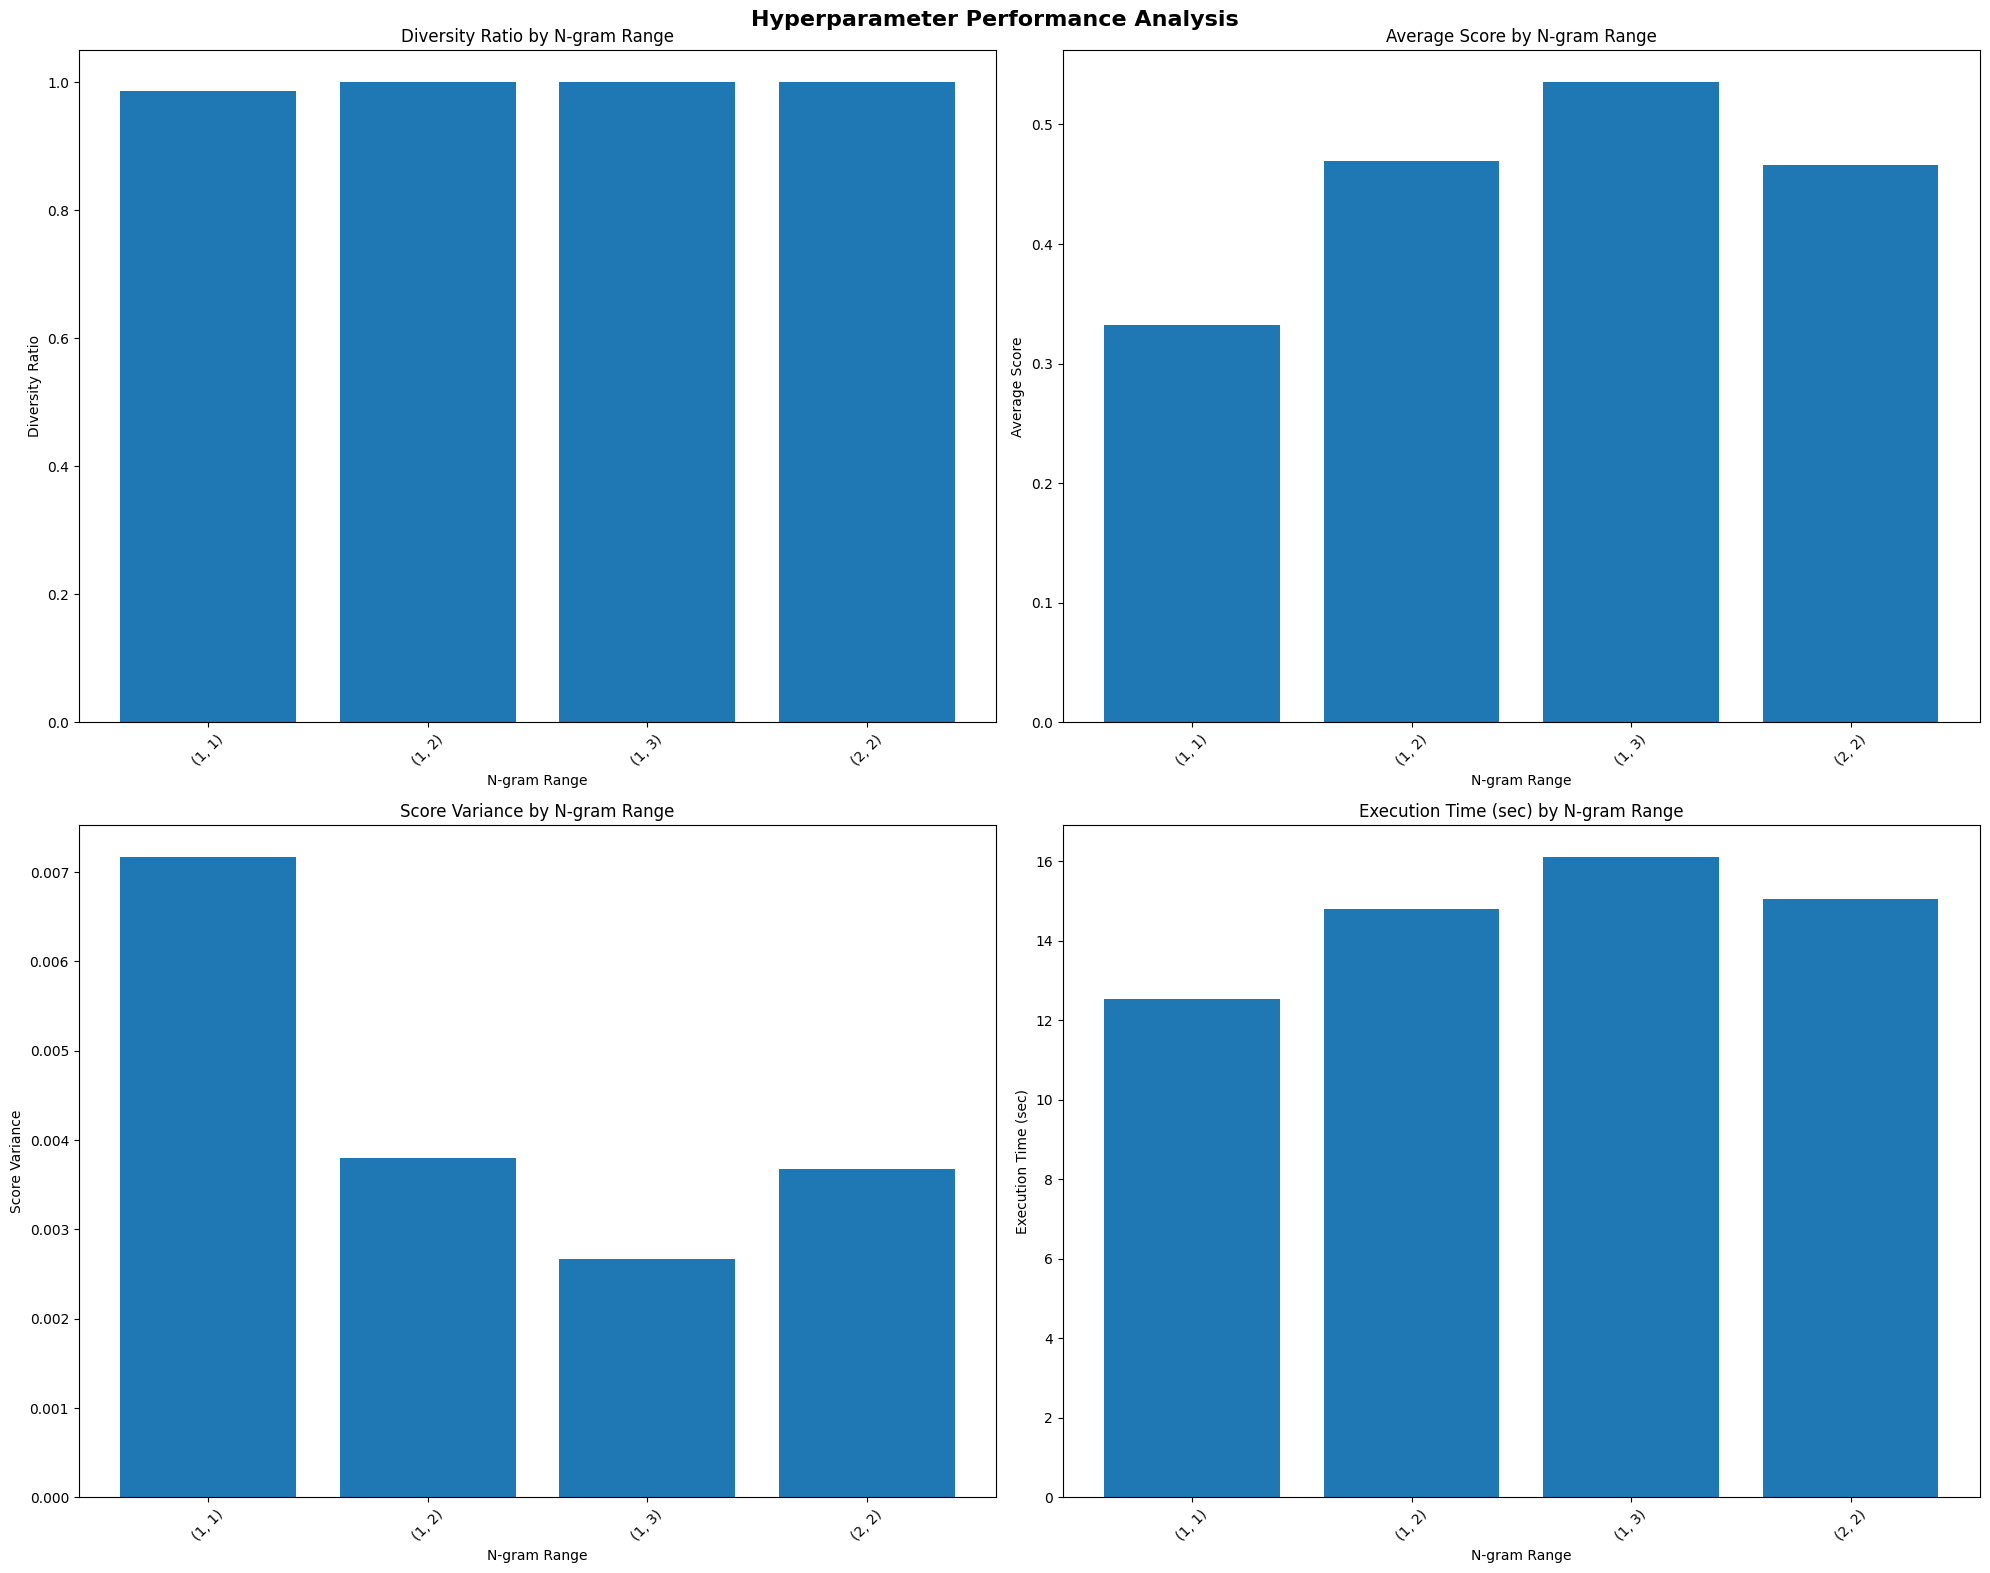

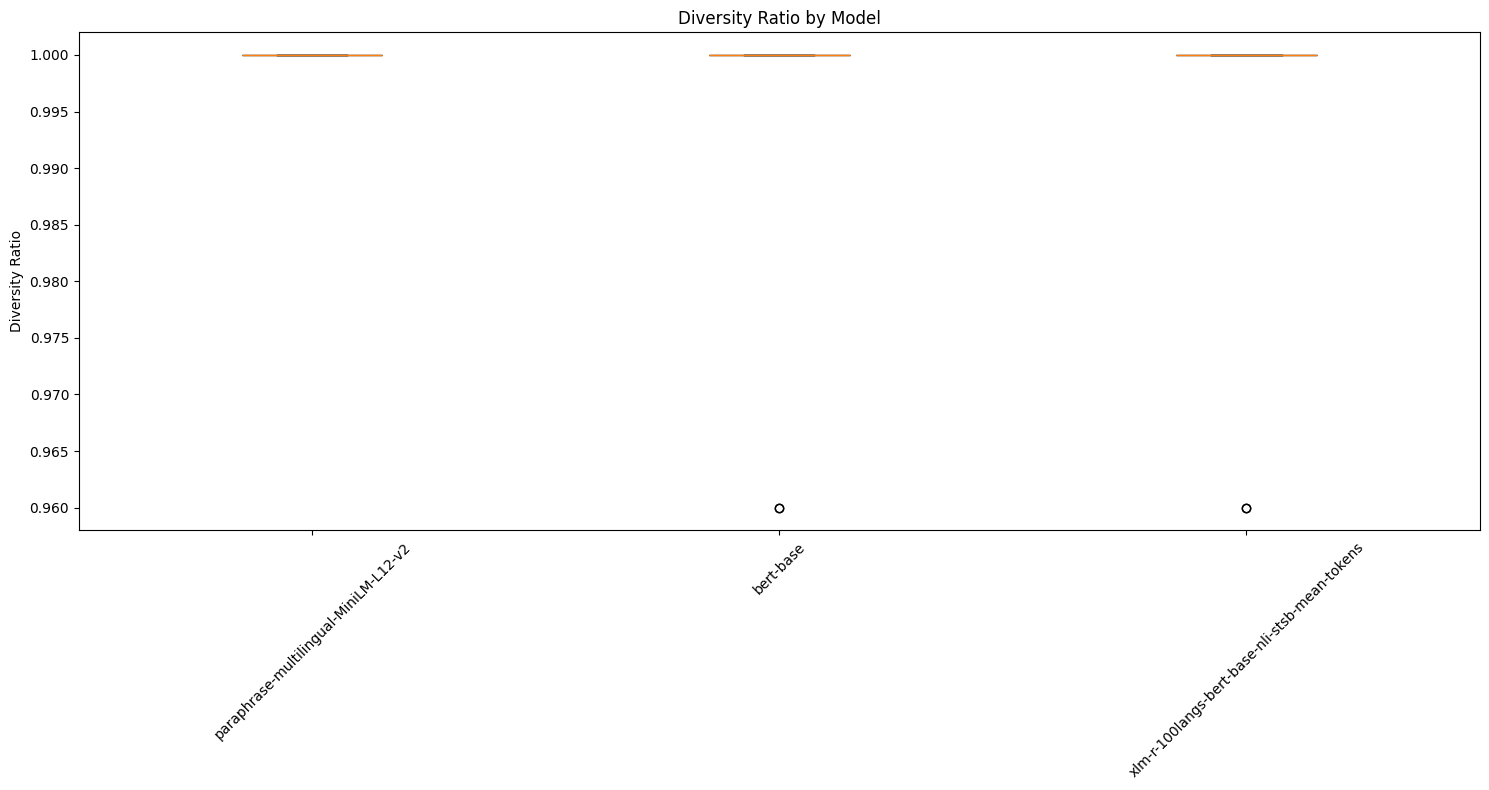

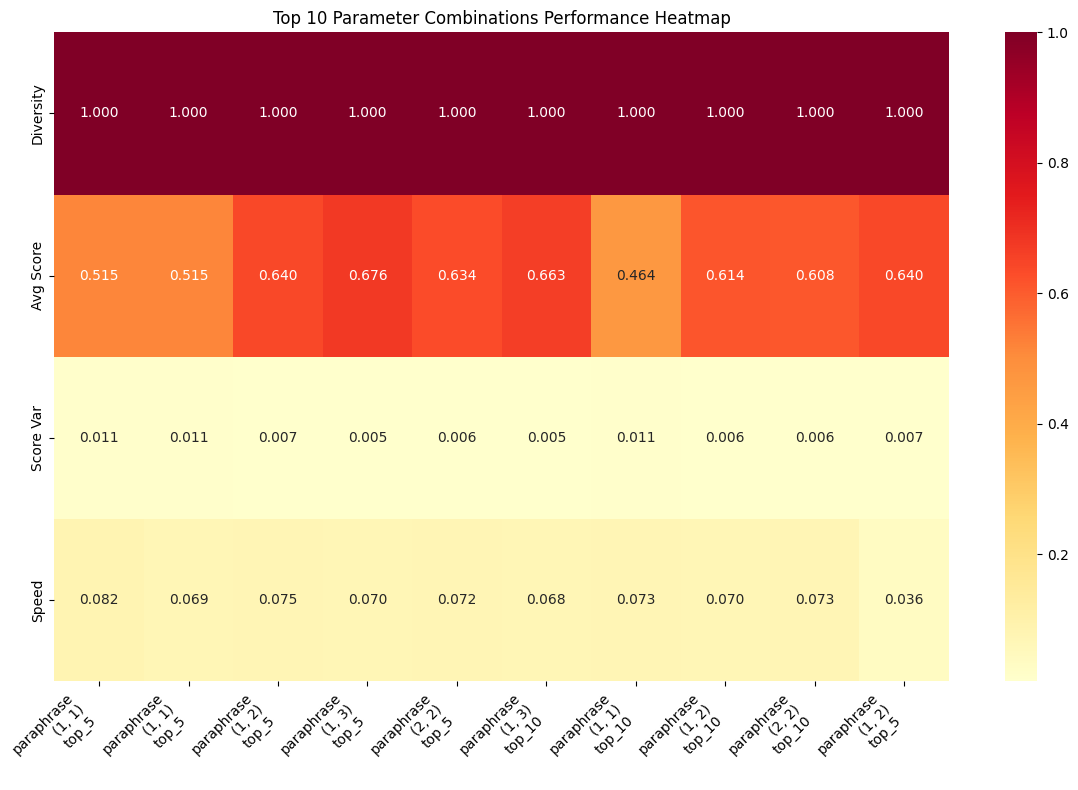

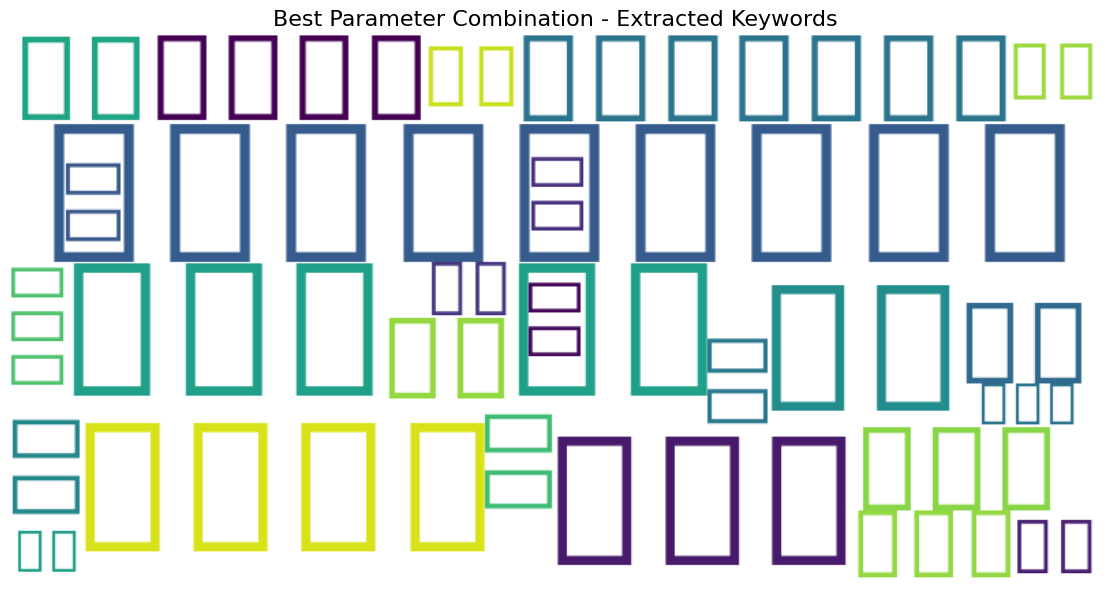

✅ 시각화 완료!

💾 결과 저장 중...
✅ 결과 저장 완료!
  - keyword_extractor_optimization_results.csv: 상세 결과
  - keyword_optimization_summary.json: 최적화 요약

📋 최적화 보고서 생성 중...
키워드 추출기 하이퍼파라미터 최적화 보고서
최적화 일시: 2025-05-26 14:50:47
테스트 기사 수: 5
테스트 파라미터 조합 수: 48

🏆 최적 파라미터 조합
----------------------------------------
📈 종합 최적 조합 (점수: 0.8532):
  • 모델: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
  • N-gram 범위: (1, 1)
  • Top-N: 5
  • 불용어 타입: extended

📊 DIVERSITY_RATIO 기준 최적:
  • 모델: paraphrase-multilingual-MiniLM-L12-v2
  • N-gram: (1, 1)
  • Top-N: 5
  • 불용어: basic
  • diversity_ratio: 1.0000

📊 AVG_SCORE 기준 최적:
  • 모델: paraphrase-multilingual-MiniLM-L12-v2
  • N-gram: (1, 3)
  • Top-N: 5
  • 불용어: basic
  • avg_score: 0.6761

📊 SCORE_VARIANCE 기준 최적:
  • 모델: paraphrase-multilingual-MiniLM-L12-v2
  • N-gram: (1, 1)
  • Top-N: 5
  • 불용어: basic
  • score_variance: 0.0109

📊 FASTEST 기준 최적:
  • 모델: bert-base
  • N-gram: (1, 2)
  • Top-N: 5
  • 불용어: basic
  • 실행시간: 5.00초

🔍 주요 발견사항
----------------------

In [7]:
optimizer = KeywordExtractorOptimizer(test_articles)
optimizer.run_full_optimization()